In [ ]:
from google.colab import drive
drive.mount('/drive')

import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm

Mounted at /drive


In [ ]:
# data from sports reference
nfl = pd.read_csv('../drive/MyDrive/data/Football/NFL_team_strength.csv')

In [ ]:
nfl.head()

,Week,Day,Date,Time,Winner/tie,Unnamed: 5,Loser/tie,Unnamed: 7,PtsW,PtsL,YdsW,TOW,YdsL,TOL
0,1,Thu,9/8/22,8:20PM,Buffalo Bills,@,Los Angeles Rams,boxscore,31,10,413,4,243,3
1,1,Sun,9/11/22,1:00PM,New Orleans Saints,@,Atlanta Falcons,boxscore,27,26,385,1,416,2
2,1,Sun,9/11/22,1:00PM,Cleveland Browns,@,Carolina Panthers,boxscore,26,24,355,0,261,1
3,1,Sun,9/11/22,1:00PM,Chicago Bears,NaN,San Francisco 49ers,boxscore,19,10,204,1,331,2
4,1,Sun,9/11/22,1:00PM,Pittsburgh Steelers,@,Cincinnati Bengals,boxscore,23,20,267,0,432,5


In [ ]:
# Rename Column for Home Identifier
nfl.rename(columns={'Unnamed: 5': 'home_identifier'}, inplace=True)

# Assign Home and Away Teams
nfl['home_team'] = np.where(nfl['home_identifier']=='@', nfl['Loser/tie'], nfl['Winner/tie'])
nfl['away_team'] = np.where(nfl['home_identifier']=='@', nfl['Winner/tie'], nfl['Loser/tie'])

## Create Target Variable
# First create home score differential
nfl['home_score_diff'] = np.where(nfl['home_identifier']=='@', nfl['PtsL']-nfl['PtsW'], nfl['PtsW']-nfl['PtsL'])

# Second create target
nfl['home_win'] = np.where(nfl['home_score_diff']>0,1,
                           np.where(nfl['home_score_diff']==0,.5,0))

In [ ]:
nfl['home_win'].value_counts() # 2 ties

,count
home_win,
1.0,151
0.0,118
0.5,2


- Let's drop matches with ties for this exercise...

In [ ]:
nfl = nfl[nfl['home_win']!=.5]
nfl['home_win'].value_counts()

,count
home_win,
1.0,151
0.0,118


In [ ]:
nfl.shape

(269, 18)

In [ ]:
# Creating target vector
y = np.array(nfl['home_win']).reshape((-1,1))
y.shape

(269, 1)

In [ ]:
y.mean() # home team wins 56% of the time

0.5613382899628253

In [ ]:
# Create array of teams in alphabetical order
teams = nfl['home_team'].sort_values().unique()

In [ ]:
def create_X(df: pd.DataFrame) -> np.ndarray:
  """
  This function creates our design matrix with rows representing
  individual games and columns representing teams. For a given team in
  a given game, 1 means the team was home, -1 means the team is away,
  0 means the team is not playing.

  Parameters:
    df: Dataframe with match-level information

  Returns:
    Design matrix
  """

  # Dimensions of X
  n = len(df)
  p = df['home_team'].nunique()

  # Initialize with 0s
  X = np.zeros((n,p))

  # Sort teams
  team_sort = df['home_team'].sort_values().unique()

  # Assign 1s and -1s accordingly
  for i in range(len(X)):

    # Obtain team names for game i
    home_team = df['home_team'].iloc[i]
    away_team = df['away_team'].iloc[i]

    # Obtain corresponding indices
    home_idx = np.where(team_sort==home_team)[0][0]
    away_idx = np.where(team_sort==away_team)[0][0]

    # Assign values
    X[i,home_idx] = 1
    X[i,away_idx] = -1

  return X



In [ ]:
X = create_X(df=nfl)


In [ ]:
X.shape

(269, 32)

In [ ]:
X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
# 5 neutral games this season
# Game 1: 10/2/2022 - Minnesota Vikings vs. New Orleans Saints
# Game 2: 10/9/2022 - New York Giants vs. Green Bay Packers
# Game 3: 10/30/2022 - Denver Broncos vs. Jacksonville Jaguar
# Game 4: 11/13/2022 - Seattle Seahawks vs. Tampa Bay Buccaneers
# Game 5: 11/21/2022 - San Francisco 49ers vs. Arizona Cardinals
idx1 = nfl[(nfl['Date']=='10/2/22') & (nfl['home_team']=='New Orleans Saints')].index.values[0]
idx2 = nfl[(nfl['Date']=='10/9/22') & (nfl['home_team']=='Green Bay Packers')].index.values[0]
idx3 = nfl[(nfl['Date']=='10/30/22') & (nfl['home_team']=='Jacksonville Jaguars')].index.values[0]
idx4 = nfl[(nfl['Date']=='11/13/22') & (nfl['home_team']=='Tampa Bay Buccaneers')].index.values[0]
idx5 = nfl[(nfl['Date']=='11/21/22') & (nfl['home_team']=='Arizona Cardinals')].index.values[0]

In [ ]:
neutral_game_list = [idx1,idx2,idx3,idx4,idx5]

In [ ]:
# Create home advantage column with zeros for neutral games
nfl['home_adv'] = 1
nfl.loc[neutral_game_list, 'home_adv'] = 0

In [ ]:
# Add home advantage column as the final column of our design matrix X, now named X_h
X_h = np.column_stack((X, nfl['home_adv']))

In [ ]:
X_h

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [ ]:
X.shape, X_h.shape # as we can see, one additionl column was added

((269, 32), (269, 33))

In [ ]:
def create_W(n_teams: int, constraint_type: int, home_adv: bool) -> np.ndarray:

  # Start with Identity Matrix
  W = np.identity(n_teams)

  # Assign -1 to all values in last row
  if constraint_type==1:
    W[-1,:] = 0
  elif constraint_type==2:
    W[-1,:] = -1
  else:
    raise ValueError("Parameter 'constraint_type' only takes values 1 or 2.")

  # Remove last team's column
  W = W[:,:-1]

  # Add block for home-advantage
  if home_adv:
    from scipy.linalg import block_diag
    W = block_diag(W, np.array(1).reshape(1,1))

  return W

In [ ]:
# Create our W matrix to account for our constraint (sum of team strengths = 0)
W = create_W(n_teams=len(teams), constraint_type=2, home_adv=False) # First, no home advantage

In [ ]:
W.shape

(32, 31)

In [ ]:
W_h = create_W(n_teams=len(teams), constraint_type=2, home_adv=True) # Now, with home advantage
W_h.shape # with home advantage

(33, 32)

In [ ]:
W_h[-2,:] # check on last row should be all zeros with final entry of 1

array([-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1.,  0.])

In [ ]:
# No closed-form solution like in linear regression
# Using statsmodels
logreg = sm.GLM(endog=y, exog = X_h @ W_h, family=sm.families.Binomial()).fit()

In [ ]:
xnames = list(teams)[:-1] # remove commanders for statsmodels output

In [ ]:
xnames = xnames + ['home_adv'] # add home advantage to bottom for statsmodels output

In [ ]:
# Print logistic regression model output
print(logreg.summary(xname=xnames))

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                  269
Model:                            GLM   Df Residuals:                      237
Model Family:                Binomial   Df Model:                           31
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -144.90
Date:                Thu, 06 Mar 2025   Deviance:                       289.81
Time:                        22:38:25   Pearson chi2:                     263.
No. Iterations:                     5   Pseudo R-squ. (CS):             0.2546
Covariance Type:            nonrobust                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Arizona Cardinals       -1.4931 

In [ ]:
np.exp(1.74)

5.697343422671991

- Philadelphia Eagles Estimated Strength: $\hat{\theta}_{PHI} = 1.74 \implies$ log-odds of winning is 1.74 units greater than league average
- Alternatively, $e^{1.74} = 5.7 \implies$ their odds of winning is 5.7 times greater than the league average odds of winning.
- Alternatively, solve for $\hat{p}$ and obtain $\hat{p}=0.85 \implies$ their probability of winning against the "average team" is 0.85.

In [ ]:
# Obtain estimated parameters from statsmodels
gamma = logreg.params
gamma.shape, gamma # 32 estimated parameters (31 teams + 1 home advantage, Washington Commanders is calculated via our constraint)

((32,),
 array([-1.49306905e+00, -7.01877168e-01,  5.78359945e-01,  1.79375039e+00,
        -6.60649830e-01, -1.27045730e+00,  1.36691992e+00, -2.34702493e-01,
         1.24024184e+00, -1.37854435e+00,  4.78910784e-01,  1.86978147e-01,
        -1.67214738e+00, -1.20838211e+00, -1.77980838e-03,  1.40602664e+00,
        -1.07598197e+00, -8.28582426e-02, -1.25027738e+00,  5.06409765e-01,
         1.52089839e+00,  9.94903530e-02, -5.48702843e-01,  5.42688813e-01,
        -4.13656444e-02,  1.74021926e+00,  3.06336979e-01,  6.63907401e-01,
        -3.01106286e-01, -2.28252236e-01, -4.61363006e-01,  3.40145807e-01]))

In [ ]:
# Separate out team parameters and home-advantage parameter
theta = gamma[:-1] # team parameters only
beta = gamma[-1] # home advantage parameter

In [ ]:
# add final team estimate (from -1*sum(team parameters))
theta_all = np.append(theta, -1*theta.sum())
theta.shape, theta_all.shape

((31,), (32,))

In [ ]:
df_ests = pd.DataFrame(columns=['Team', 'Strengths'])
df_ests['Team'] = teams
df_ests['Strengths'] = theta_all
df_ests.head()

,Team,Strengths
0,Arizona Cardinals,-1.493069
1,Atlanta Falcons,-0.701877
2,Baltimore Ravens,0.578360
3,Buffalo Bills,1.793750
4,Carolina Panthers,-0.660650


In [ ]:
df_strengths = pd.DataFrame(columns=['Team','Strengths','Std_Error'])
df_strengths['Team'] = list(teams)+ ['Home-Field Adv']
df_strengths['Strengths'] = np.append(theta_all, beta)


In [ ]:
df_strengths

,Team,Strengths,Std_Error
0,Arizona Cardinals,-1.493069,NaN
1,Atlanta Falcons,-0.701877,NaN
2,Baltimore Ravens,0.578360,NaN
3,Buffalo Bills,1.793750,NaN
4,Carolina Panthers,-0.660650,NaN
5,Chicago Bears,-1.270457,NaN
6,Cincinnati Bengals,1.366920,NaN
7,Cleveland Browns,-0.234702,NaN
8,Dallas Cowboys,1.240242,NaN
9,Denver Broncos,-1.378544,NaN


<ipython-input-37-ad0f047332c6>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(df_ests.sort_values('Strengths',ascending=False), y='Team', x='Strengths',orient='h', palette=color_palette)


Text(0.5, 0, 'Team Strengths')

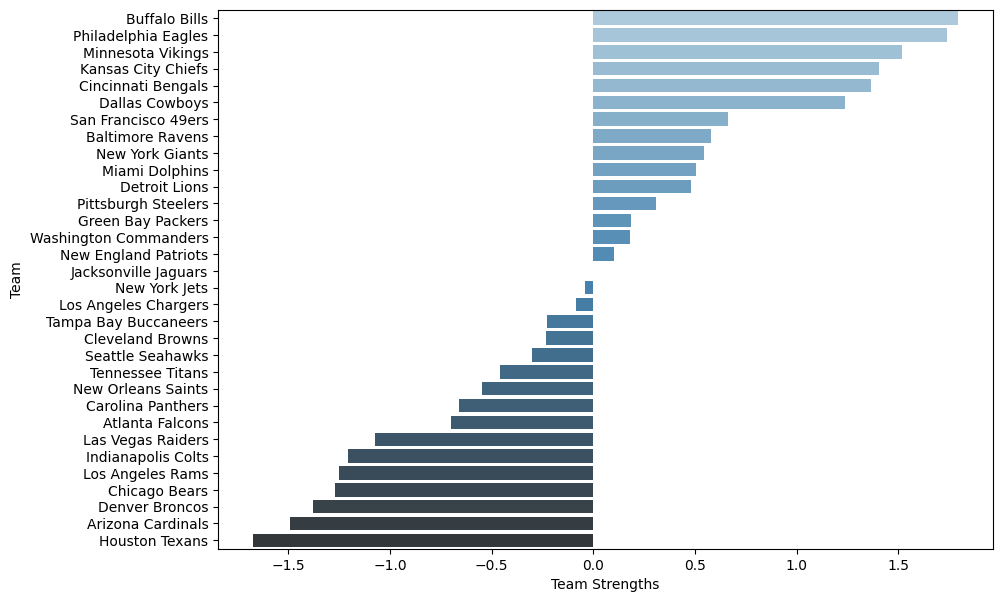

In [ ]:
plt.figure(figsize=(10,7))
color_palette = sns.color_palette('Blues_d', len(df_ests))
sns.barplot(df_ests.sort_values('Strengths',ascending=False), y='Team', x='Strengths',orient='h', palette=color_palette)
plt.xlabel('Team Strengths')

In [ ]:
# Standard errors
vcov = logreg.cov_params()
std_errors = np.sqrt(np.diagonal(vcov))
print(f"vcov: {vcov.shape}")
print(std_errors)

vcov: (32, 32)
[0.61517211 0.54281271 0.53911071 0.67575694 0.54720482 0.68469405
 0.60740637 0.53683358 0.60616147 0.58859663 0.54218586 0.55809215
 0.66863606 0.63449617 0.5607633  0.69735005 0.56982114 0.54880066
 0.60241007 0.54361649 0.64133651 0.54868284 0.55946457 0.58219098
 0.53960587 0.68646911 0.55176487 0.60027659 0.54955843 0.54011627
 0.59018459 0.14752915]


What is the variance of the reference team's parameter estimate?
$$Var(\hat{\theta}_{WAS}) = Var\bigg(-\sum_{i=1}^{p-1}\hat{\theta}_i\bigg) = \sum_{i=1}^{p-1}Var(\hat{\theta})+2\sum_{i < j}Cov(\hat{\theta}_i, \hat{\theta}_j)$$
In other words, this is just the sum of each entry for the covariance matrix among $\hat{\boldsymbol{\theta}}$.

In [ ]:
theta_cov = vcov[:-1,:-1]

In [ ]:
theta_cov.shape

(31, 31)

In [ ]:
var_was = theta_cov.sum()

In [ ]:
print(f"Variance of Washington Commanders Strength Estimator: {var_was}")
print(f"Standard Error for Washington Commanders Strength: {np.sqrt(var_was)}")

Variance of Washington Commanders Strength Estimator: 0.3249104787878976
Standard Error for Washington Commanders Strength: 0.5700091918450944


In [ ]:
# Don't worry about this...check: np.triu(theta_cov,k=1).sum()*2 + np.diagonal(theta_cov).sum()

In [ ]:
std_errs_v = np.append(np.sqrt(np.diagonal(theta_cov)), np.sqrt(var_was))
std_errs_v = np.append(std_errs_v, np.sqrt(vcov[-1,-1]))
df_strengths['Std_Error'] = std_errs_v

In [ ]:
display(df_strengths.head())
display(df_strengths.tail())

,Team,Strengths,Std_Error
0,Arizona Cardinals,-1.493069,0.615172
1,Atlanta Falcons,-0.701877,0.542813
2,Baltimore Ravens,0.578360,0.539111
3,Buffalo Bills,1.793750,0.675757
4,Carolina Panthers,-0.660650,0.547205


,Team,Strengths,Std_Error
28,Seattle Seahawks,-0.301106,0.549558
29,Tampa Bay Buccaneers,-0.228252,0.540116
30,Tennessee Titans,-0.461363,0.590185
31,Washington Commanders,0.180378,0.570009
32,Home-Field Adv,0.340146,0.147529


In [ ]:
# Rearrange the above table to have the team strengths sorted from greatest to least and put home advantage at the bottom
df_strengths_teams = df_strengths.iloc[:-1,:]
df_strengths_teams = df_strengths_teams.sort_values('Strengths', ascending=False)
df_strengths_teams = pd.concat([df_strengths_teams, pd.DataFrame(df_strengths.iloc[-1,:]).T], ignore_index=True, axis=0)

In [ ]:
df_strengths_teams.to_csv('../drive/MyDrive/data/Football/NFL_team_strength_logreg_est.csv', index=False)

In [ ]:
df_strengths_teams

,Team,Strengths,Std_Error
0,Buffalo Bills,1.79375,0.675757
1,Philadelphia Eagles,1.740219,0.686469
2,Minnesota Vikings,1.520898,0.641337
3,Kansas City Chiefs,1.406027,0.69735
4,Cincinnati Bengals,1.36692,0.607406
5,Dallas Cowboys,1.240242,0.606161
6,San Francisco 49ers,0.663907,0.600277
7,Baltimore Ravens,0.57836,0.539111
8,New York Giants,0.542689,0.582191
9,Miami Dolphins,0.50641,0.543616


## Let's use this model for predicting game outcomes for the 2023 NFL season

In [ ]:
nfl23_path = '../drive/MyDrive/data/Football/nfl_2023.csv'
nfl23 = pd.read_csv(nfl23_path)

In [ ]:
display(nfl23.head())
display(nfl23.tail(15)) # regular season ends at index 288 (289th row)

,Week,Day,Date,Time,Winner/tie,Unnamed: 5,Loser/tie,Unnamed: 7,PtsW,PtsL,YdsW,TOW,YdsL,TOL
0,1,Thu,2023-09-07,8:20PM,Detroit Lions,@,Kansas City Chiefs,boxscore,21,20,368,1,316,1
1,1,Sun,2023-09-10,1:00PM,Atlanta Falcons,NaN,Carolina Panthers,boxscore,24,10,221,0,281,3
2,1,Sun,2023-09-10,1:00PM,Cleveland Browns,NaN,Cincinnati Bengals,boxscore,24,3,350,2,142,0
3,1,Sun,2023-09-10,1:00PM,Jacksonville Jaguars,@,Indianapolis Colts,boxscore,31,21,342,2,280,3
4,1,Sun,2023-09-10,1:00PM,Washington Commanders,NaN,Arizona Cardinals,boxscore,20,16,248,3,210,2


,Week,Day,Date,Time,Winner/tie,Unnamed: 5,Loser/tie,Unnamed: 7,PtsW,PtsL,YdsW,TOW,YdsL,TOL
288,18,Sun,2024-01-07,8:20PM,Buffalo Bills,@,Miami Dolphins,boxscore,21,14,473,3,275,2
289,NaN,NaN,Playoffs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
290,WildCard,Sat,2024-01-13,4:30PM,Houston Texans,NaN,Cleveland Browns,boxscore,45,14,356,0,324,2
291,WildCard,Sat,2024-01-13,8:10PM,Kansas City Chiefs,NaN,Miami Dolphins,boxscore,26,7,409,1,264,1
292,WildCard,Sun,2024-01-14,4:30PM,Green Bay Packers,@,Dallas Cowboys,boxscore,48,32,415,0,510,2
293,WildCard,Sun,2024-01-14,8:15PM,Detroit Lions,NaN,Los Angeles Rams,boxscore,24,23,334,0,425,0
294,WildCard,Mon,2024-01-15,4:30PM,Buffalo Bills,NaN,Pittsburgh Steelers,boxscore,31,17,368,0,324,2
295,WildCard,Mon,2024-01-15,8:15PM,Tampa Bay Buccaneers,NaN,Philadelphia Eagles,boxscore,32,9,426,0,276,0
296,Division,Sat,2024-01-20,4:30PM,Baltimore Ravens,NaN,Houston Texans,boxscore,34,10,352,0,213,0
297,Division,Sat,2024-01-20,8:15PM,San Francisco 49ers,NaN,Green Bay Packers,boxscore,24,21,356,0,330,2


In [ ]:
nfl23 = nfl23.iloc[:289,:]
nfl23 = nfl23[nfl23['Week']!='Week']

In [ ]:
nfl23.tail()

,Week,Day,Date,Time,Winner/tie,Unnamed: 5,Loser/tie,Unnamed: 7,PtsW,PtsL,YdsW,TOW,YdsL,TOL
284,18,Sun,2024-01-07,4:25PM,Las Vegas Raiders,NaN,Denver Broncos,boxscore,27,14,359,0,286,1
285,18,Sun,2024-01-07,4:25PM,Kansas City Chiefs,@,Los Angeles Chargers,boxscore,13,12,268,1,353,1
286,18,Sun,2024-01-07,4:25PM,New York Giants,NaN,Philadelphia Eagles,boxscore,27,10,415,1,299,4
287,18,Sun,2024-01-07,4:25PM,Los Angeles Rams,@,San Francisco 49ers,boxscore,21,20,258,1,300,1
288,18,Sun,2024-01-07,8:20PM,Buffalo Bills,@,Miami Dolphins,boxscore,21,14,473,3,275,2


In [ ]:
# Neutral games
idx1 = 52
idx2 = 69
idx3 = 84
idx4 = 131
idx5 = 146
neutral_game_list23 = [idx1, idx2, idx3, idx4, idx5]

In [ ]:
nfl23['PtsL'] = nfl23['PtsL'].astype('int64')
nfl23['PtsW'] = nfl23['PtsW'].astype('int64')

In [ ]:
# Carry out the same data processing steps as before...
nfl23.rename(columns={'Unnamed: 5': 'home_identifier'}, inplace=True)

nfl23['home_team'] = np.where(nfl23['home_identifier']=='@', nfl23['Loser/tie'], nfl23['Winner/tie'])
nfl23['away_team'] = np.where(nfl23['home_identifier']=='@', nfl23['Winner/tie'], nfl23['Loser/tie'])

nfl23['home_score_diff'] = np.where(nfl23['home_identifier']=='@', nfl23['PtsL']-nfl23['PtsW'], nfl23['PtsW']-nfl23['PtsL'])

nfl23['home_win'] = np.where(nfl23['home_score_diff']>0,1,
                           np.where(nfl23['home_score_diff']==0,.5,0))


In [ ]:
nfl23['home_win'].value_counts() # 0 ties

,count
home_win,
1.0,151
0.0,121


In [ ]:
nfl23 = nfl23[nfl23['home_win']!=.5] # won't do anything since there are no ties anyway
nfl23['home_win'].value_counts()

,count
home_win,
1.0,151
0.0,121


In [ ]:
# Creating test target vector
y23 = np.array(nfl23['home_win']).reshape((-1,1))
y23.shape

(272, 1)

In [ ]:
# Create home advantage column with zeros for neutral games
nfl23['home_adv'] = 1
nfl23.loc[neutral_game_list23, 'home_adv'] = 0

In [ ]:
# Create test design matrix
X23 = create_X(df=nfl23)

In [ ]:
X23.shape

(272, 32)

In [ ]:
X23_h = np.column_stack((X23, nfl23['home_adv']))
X23_h.shape

(272, 33)

In [ ]:
coefs = np.append(theta_all, beta).reshape((-1,1))

In [ ]:
coefs.shape

(33, 1)

In [ ]:
y23_pred = X23_h @ coefs
y23_pred_probs = 1/(1+np.exp(-y23_pred)) # convert log-odds to probabilities

<Axes: ylabel='Count'>

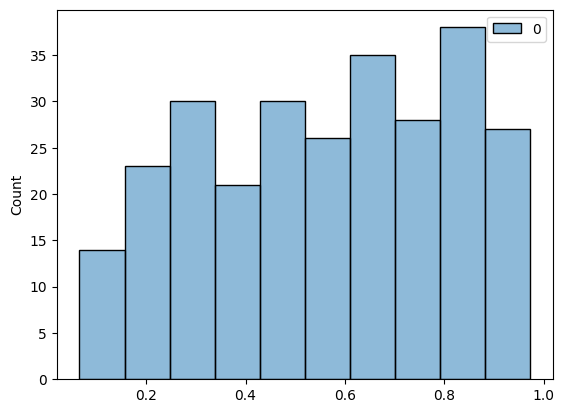

In [ ]:
sns.histplot(y23_pred_probs)

<Axes: ylabel='Count'>

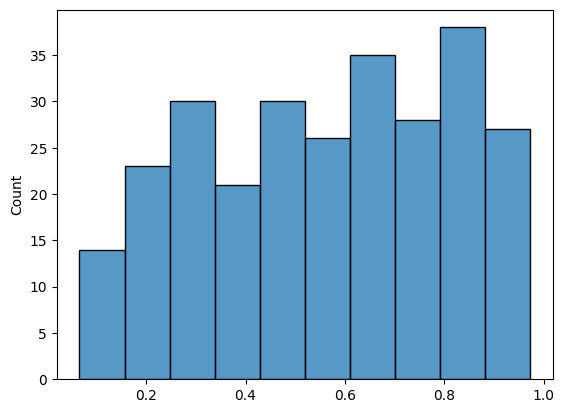

In [ ]:
sns.histplot(logreg.predict(X23_h @ W_h))

In [ ]:
# Alternatively using statsmodels
# logreg.predict(X23_h @ W_h)

In [ ]:
# Use a 0.5 threshold
nfl23['y23_pred_log_odds'] = y23_pred
nfl23['y23_pred_probs'] = y23_pred_probs
nfl23['pred_home_win_0.5'] = np.where(nfl23['y23_pred_probs']>.5,1,0)
nfl23.head()

,Week,Day,Date,Time,Winner/tie,home_identifier,Loser/tie,Unnamed: 7,PtsW,PtsL,...,YdsL,TOL,home_team,away_team,home_score_diff,home_win,home_adv,y23_pred_log_odds,y23_pred_probs,pred_home_win_0.5
0,1,Thu,2023-09-07,8:20PM,Detroit Lions,@,Kansas City Chiefs,boxscore,21,20,...,316,1,Kansas City Chiefs,Detroit Lions,-1,0.0,1,1.267262,0.780274,1
1,1,Sun,2023-09-10,1:00PM,Atlanta Falcons,NaN,Carolina Panthers,boxscore,24,10,...,281,3,Atlanta Falcons,Carolina Panthers,14,1.0,1,0.298918,0.574178,1
2,1,Sun,2023-09-10,1:00PM,Cleveland Browns,NaN,Cincinnati Bengals,boxscore,24,3,...,142,0,Cleveland Browns,Cincinnati Bengals,21,1.0,1,-1.261477,0.220720,0
3,1,Sun,2023-09-10,1:00PM,Jacksonville Jaguars,@,Indianapolis Colts,boxscore,31,21,...,280,3,Indianapolis Colts,Jacksonville Jaguars,-10,0.0,1,-0.866456,0.295992,0
4,1,Sun,2023-09-10,1:00PM,Washington Commanders,NaN,Arizona Cardinals,boxscore,20,16,...,210,2,Washington Commanders,Arizona Cardinals,4,1.0,1,2.013593,0.882217,1


In [ ]:
pd.crosstab(nfl23['home_win'], nfl23['pred_home_win_0.5'])

pred_home_win_0.5,0,1
home_win,,
0.0,63,58
1.0,48,103


In [ ]:
(nfl23['home_win'] == nfl23['pred_home_win_0.5']).mean()

0.6102941176470589

In [ ]:
# How is our accuracy week-to-week?
nfl23['Week'] = nfl23['Week'].astype('int64')
max_week = nfl23['Week'].max()
min_week = nfl23['Week'].min()
acc = []
cumulative_acc = []
for wk in range(min_week, max_week+1):

  # Subset by week
  nfl_wk = nfl23[nfl23['Week']==wk]

  # Weekly accuracy
  acc_wk = (nfl_wk['home_win']==nfl_wk['pred_home_win_0.5']).mean()
  acc.append(acc_wk)

  # Subset through week
  nfl_cum_wk = nfl23[nfl23['Week']<=wk]
  cum_acc_wk = (nfl_cum_wk['home_win']==nfl_cum_wk['pred_home_win_0.5']).mean()
  cumulative_acc.append(cum_acc_wk)

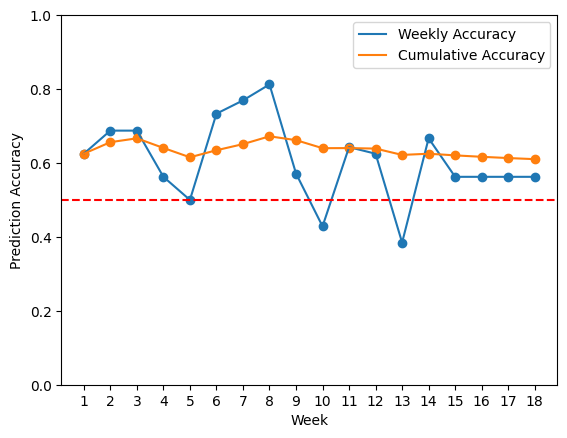

In [ ]:
plt.plot(range(min_week, max_week+1), acc, label='Weekly Accuracy')
plt.scatter(range(min_week, max_week+1), acc)
plt.plot(range(min_week, max_week+1), cumulative_acc, label='Cumulative Accuracy')
plt.scatter(range(min_week, max_week+1), cumulative_acc)
plt.axhline(y=.5, color='red', linestyle='dashed')
plt.ylim([0,1])
plt.xticks(range(min_week, max_week+1))
plt.ylabel('Prediction Accuracy')
plt.xlabel('Week')
plt.legend(loc='best')

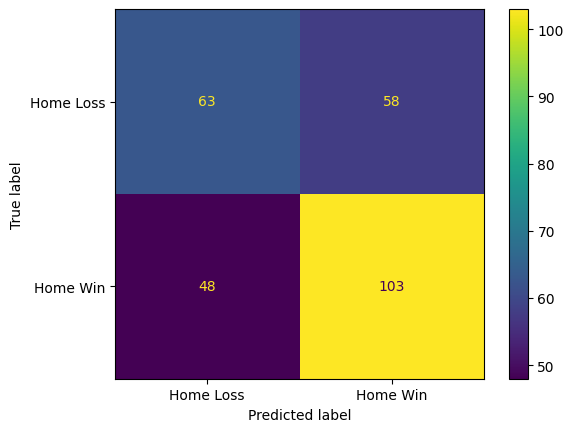

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(nfl23['home_win'], nfl23['pred_home_win_0.5'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = ['Home Loss', 'Home Win'])
disp.plot()

In [ ]:
nfl23['home_win'].sum(), nfl23['home_win'].mean()

(151.0, 0.5551470588235294)

In [ ]:
166/272 # Accuracy

0.6102941176470589

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(nfl23['home_win'], nfl23['pred_home_win_0.5']))

              precision    recall  f1-score   support

         0.0       0.57      0.52      0.54       121
         1.0       0.64      0.68      0.66       151

    accuracy                           0.61       272
   macro avg       0.60      0.60      0.60       272
weighted avg       0.61      0.61      0.61       272



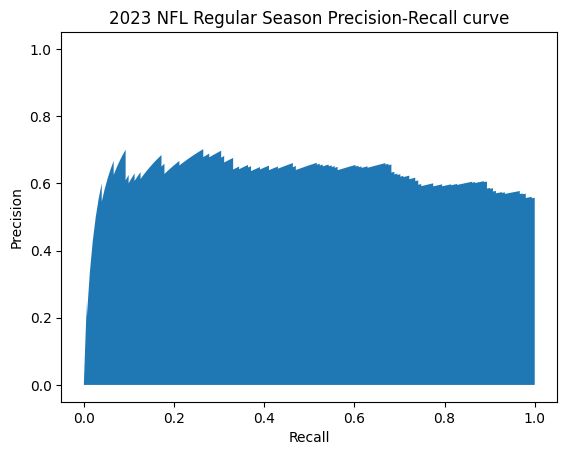

In [ ]:
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(nfl23['home_win'], nfl23['y23_pred_probs'])
plt.fill_between(recall, precision)
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.title("2023 NFL Regular Season Precision-Recall curve");

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve
roc_auc_score(nfl23['home_win'], nfl23['y23_pred_probs'])

0.6142520934814734

In [ ]:
fpr, tpr, _ = roc_curve(nfl23['home_win'], nfl23['y23_pred_probs'])

Text(0, 0.5, 'True Positive Rate')

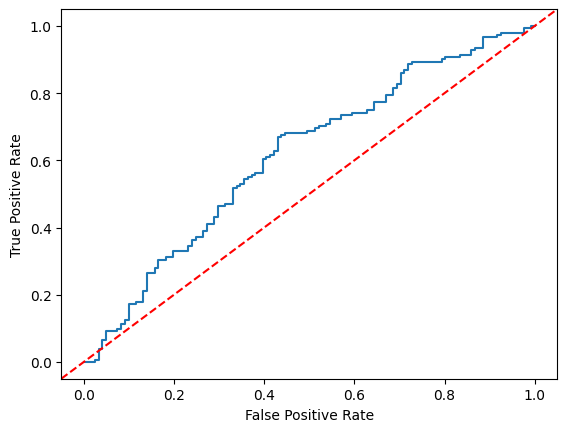

In [ ]:
plt.plot(fpr, tpr)
plt.axline((0,0), slope=1, color='red', linestyle='dashed')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

In [ ]:
nfl23['home_win'].mean()

0.5551470588235294

<Axes: ylabel='Count'>

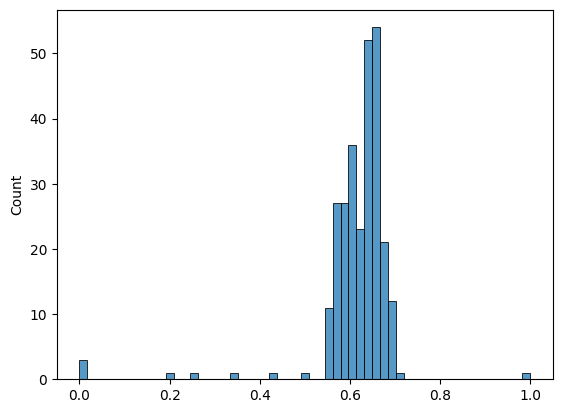

In [ ]:
sns.histplot(precision)

<Axes: ylabel='Count'>

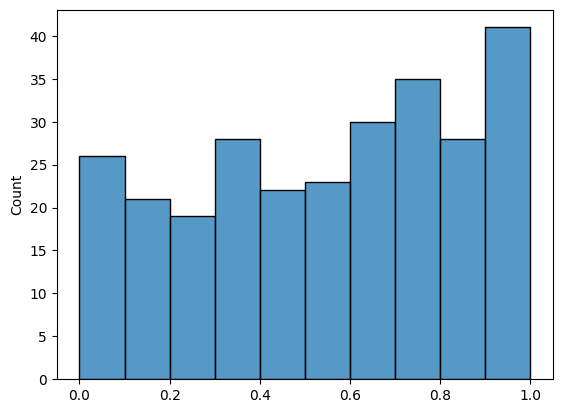

In [ ]:
sns.histplot(recall)

# Assessing the Predicted Probabilities of our Logistic Regression Model

In [ ]:
def brier_score(y_true, pred_probs):
  return ((y_true-pred_probs)**2).mean()

def log_loss(y_true, pred_probs):
  return -(y_true*np.log(pred_probs)+(1-y_true)*np.log(1-pred_probs)).sum()

In [ ]:
# Model Comparison
print("Brier Score Comparison...")
print(f"Always Predict Home Wins: {np.round(brier_score(y_true=nfl23['home_win'], pred_probs=1),2)}")
print(f"Always Predict Home Wins with Prob 1/2: {np.round(brier_score(y_true=nfl23['home_win'], pred_probs=.5),2)}")
print(f"Logistic Regression Mode: {np.round(brier_score(y_true=nfl23['home_win'], pred_probs=nfl23['y23_pred_probs']),2)}")

Brier Score Comparison...
Always Predict Home Wins: 0.44
Always Predict Home Wins with Prob 1/2: 0.25
Logistic Regression Mode: 0.26


In [ ]:
# Model Comparison
print("Log-Loss Comparison...")
print(f"Always Predict Home Wins: {np.round(log_loss(y_true=nfl23['home_win'], pred_probs=1),2)}")
print(f"Always Predict Home Wins with Prob 1/2: {np.round(log_loss(y_true=nfl23['home_win'], pred_probs=.5),2)}")
print(f"Logistic Regression Mode: {np.round(log_loss(y_true=nfl23['home_win'], pred_probs=nfl23['y23_pred_probs']),2)}")

Log-Loss Comparison...
Always Predict Home Wins: inf
Always Predict Home Wins with Prob 1/2: 188.54
Logistic Regression Mode: 203.65


<ipython-input-82-8e599c0a318e>:5: RuntimeWarning: divide by zero encountered in log
  return -(y_true*np.log(pred_probs)+(1-y_true)*np.log(1-pred_probs)).sum()


- The probabilistic forecasts of our model are worse than a random coin flip...

In [ ]:
nfl23.head()

,Week,Day,Date,Time,Winner/tie,home_identifier,Loser/tie,Unnamed: 7,PtsW,PtsL,...,YdsL,TOL,home_team,away_team,home_score_diff,home_win,home_adv,y23_pred_log_odds,y23_pred_probs,pred_home_win_0.5
0,1,Thu,2023-09-07,8:20PM,Detroit Lions,@,Kansas City Chiefs,boxscore,21,20,...,316,1,Kansas City Chiefs,Detroit Lions,-1,0.0,1,1.267262,0.780274,1
1,1,Sun,2023-09-10,1:00PM,Atlanta Falcons,NaN,Carolina Panthers,boxscore,24,10,...,281,3,Atlanta Falcons,Carolina Panthers,14,1.0,1,0.298918,0.574178,1
2,1,Sun,2023-09-10,1:00PM,Cleveland Browns,NaN,Cincinnati Bengals,boxscore,24,3,...,142,0,Cleveland Browns,Cincinnati Bengals,21,1.0,1,-1.261477,0.220720,0
3,1,Sun,2023-09-10,1:00PM,Jacksonville Jaguars,@,Indianapolis Colts,boxscore,31,21,...,280,3,Indianapolis Colts,Jacksonville Jaguars,-10,0.0,1,-0.866456,0.295992,0
4,1,Sun,2023-09-10,1:00PM,Washington Commanders,NaN,Arizona Cardinals,boxscore,20,16,...,210,2,Washington Commanders,Arizona Cardinals,4,1.0,1,2.013593,0.882217,1


In [ ]:
from sklearn.calibration import calibration_curve

In [ ]:
true_home_win_probs, pred_home_win_probs = calibration_curve(nfl23['home_win'], nfl23['y23_pred_probs'], n_bins=10)

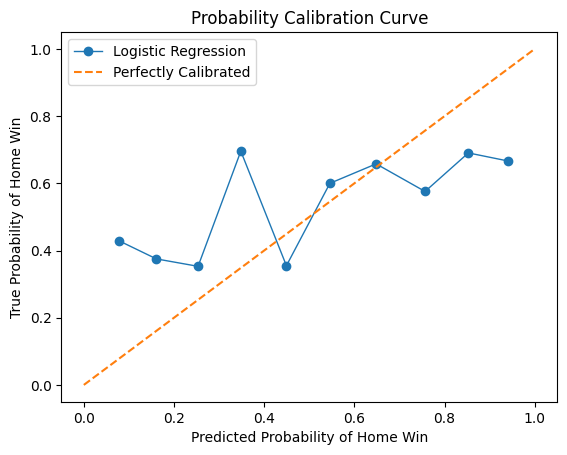

In [ ]:
plt.plot(pred_home_win_probs,
         true_home_win_probs,
         marker='o',
         linewidth=1,
         label='Logistic Regression')
plt.plot([0, 1],
         [0, 1],
         linestyle='--',
         label='Perfectly Calibrated')

plt.xlabel('Predicted Probability of Home Win')
plt.ylabel('True Probability of Home Win')
plt.title('Probability Calibration Curve')
plt.legend(loc='best')